# ExploreModel
In this code we aim to explore the model problem
$$y' = \lambda y,\quad y(0) = 1$$
where observations are of the form
$$z_i = y(t_i) + \varepsilon_i,\quad \varepsilon_i \sim \mathcal{N}(0,\sigma),$$
and the unknown is $\lambda$.

In [1]:
# load packages
import numpy as np
import pandas as pd

from math import exp, pi

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

np.random.seed(0)

Consider $\lambda$ = -2.5, a discretization $\Delta t$, on the interval $t = [0,1]$

In [2]:
lam = -2.5
delta_t = 0.1
interval_T = [0,1]

The Analytical solution to the model problem follows
$$ y(t) = e^{\lambda t}.$$
Generate a vector $y$ on the interval $t$ with the given discretization $\Delta t$

In [3]:
def model_analytic(constant, t_vec):
    y = np.zeros(len(t_vec))
    for i in range(len(t_vec)):
        t = t_vec[i]    
        if(t == 0):
            y[i] = 1
        else:
            y[i] = exp(constant*t)
    return(y)

In [4]:
num_step = int((interval_T[1]-interval_T[0])/delta_t) ## needs to be integer, because: "number of steps"
t_vec = np.linspace(start=interval_T[0], stop=interval_T[1], num=num_step)
y_vec = model_analytic(lam, t_vec)

Plot the solution as a scatter plot

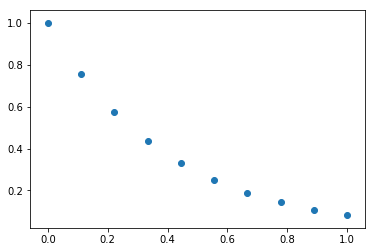

In [5]:
plt.scatter(x=t_vec,y=y_vec)
plt.show()

This is the underlying truth.

Now, consider noisy observations, $z_i = y(t_i) + \varepsilon_i$,
where $\varepsilon_i \sim \mathcal{N}(0,\sigma)$, and $\sigma = 1$ 

In [6]:
def observation(y_vec, scale):
    z_vec = y_vec + np.random.normal(loc=0,scale=scale, size=len(y_vec))
    return(z_vec)

In [7]:
scale = 1
z_0 = observation(y_vec, scale)
z_1 = observation(y_vec, scale)

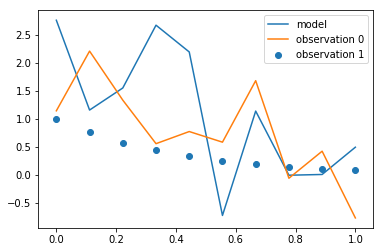

In [8]:
plt.scatter(t_vec, y_vec)
plt.plot(t_vec, z_0, '-')
plt.plot(t_vec, z_1, '-')

plt.legend(["model","observation 0", "observation 1"])
plt.show()

Now consider $N_\text{samples}$ of $z$.

In [9]:
df = pd.DataFrame({"t": t_vec, "y":y_vec})
N_samples = 100
for n in range(N_samples):
    name = "z_" + str(n)
    df[name] = observation(y_vec, scale)



plot all $N_\text{samples}$

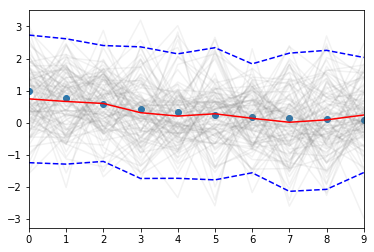

In [10]:
df.iloc[:,2:].plot(color="grey", alpha=0.1, legend=False)
## moments
df_mean = df.iloc[:,2:].mean(axis=1)
df_std = df.iloc[:,2:].std(axis=1)
plt.plot(df_mean, color="red")
plt.plot(df_mean + 2*df_std, "--b")
plt.plot(df_mean - 2*df_std, "--b")

## observation
plt.scatter(x=range(len(y_vec)), y = y_vec)
plt.show()

# Posterior-sampler

Now, consider given the observation. Can we find the unknown random variable $\lambda$ via Bayesian Inversion?

Assume the prior $P(\lambda) = \mathcal{N}(0,1)$,

additative normal dist. noise, $\varepsilon \sim \mathcal{N}(0,\sigma)$.

We then have the likelihood, for a observation (series) $\mathbf{z} = (z_1, \dots, z_T)$,
$$P(\mathbf{z} | \lambda) = \frac{1}{{(2\pi)}^{T/2} \sigma^T} \exp{\big( \frac{-1}{2 \sigma^2} |G(\lambda,t_1) - z_1|^2 \big)} \exp{\big( \frac{-1}{2 \sigma^2} |G(\lambda,t_2) - z_2|^2 \big)} \cdots \exp{\big( \frac{-1}{2 \sigma^2} |G(\lambda,t_T) - z_T|^2 \big)} = $$ 
$$ = \frac{1}{{(2\pi)}^{T/2} \sigma^T} \exp{\big( \frac{-1}{2 \sigma^2} \sum_{i=1}^T |G(\lambda,t_i) - z_i|^2 \big)} $$

and the log likelihood as 
$$l(\theta) = \log P(\mathbf{z} | \lambda) = - T \log \bigg( (2\pi)^{1/2} \sigma \bigg) - \frac{1}{2 \sigma^2} \sum_i^T |G(\lambda,t_i) - z_i|^2 $$

Now we assume that we have multiple observations, say $N_\text{data} = N$ many, i.e., $z_1 = [z_1^1, z_1^2, \ldots, z_1^N]^T$.



We write the likelihood at time $t_1$ as,
$$ P(z_1 | \lambda) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\bigg( \frac{-1}{2\sigma^2} \frac{1}{N} \sum_{j=1}^N |G(\lambda, t_1) - z_1^j|^2 \bigg) },$$

and we can also write $|G(\lambda,t_1) - z_1^j|^2$ as $w_1^j$, which in the particle filter setting is refered to as "weights". We simplify, and write,
$$ P(z_1 | \lambda) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\bigg( \frac{-1}{2\sigma^2} \frac{1}{N} \sum_{j=1}^N w_1^j \bigg) },$$

additionally, we define $\tilde{\bar{w}}_1 := \sum_{j=1}^N w_1^j$, and get, $$ P(z_1 | \lambda) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\bigg( \frac{-1}{2\sigma^2} \tilde{\bar{w}}_1 \bigg) }.$$

Finally, if we now extend this with all observations in time, $z_{1:T}$, we get
$$ P(z_1 | \lambda) = \frac{1}{(2\pi)^{T/2}\sigma^T} \exp{\bigg( \frac{-1}{2\sigma^2} \sum_{i=1}^T \tilde{\bar{w}}_i \bigg) },$$

or in log-form,
$$ p(z_1 | \lambda) = -T \log\big( (2\pi)^{1/2}\sigma \big) - \frac{1}{2\sigma^2} \sum_{i=1}^T \tilde{\bar{w}}_i.$$

### Deploy a (boring) Metropolis-Hastings algorithm

In [11]:
def prior_func(eps, loc, scale, log=False):
    if(log):
        pdf = norm.logpdf(eps, loc, scale)
    else:
        pdf = norm.pdf(eps, loc, scale)
    return(pdf)


In [150]:
# use a class structre
class MetropolisHastings:
    # in proposal we need a step lenght
    def __init__(self, prior, noise, delta_T, log, random_state=0):
        self.random_state = random_state
        self.posterior = np.empty([0])
        self.likelihood_traj = np.empty([0])
        self.prior = prior
        self.noise = noise
        self.delta_T = delta_T
        self.log = log
        
    def reSeed(self, random_state):
        self.random_state=random_state
                        
    # find the posterior given the observation
    def fit(self, data, N_sample, start, step, silent = False):
        np.random.seed(self.random_state)
        posterior = np.empty([N_sample])
        likelihood_traj = np.empty([N_sample])
        
        if(not silent):
            print("run loop for: ", N_sample)
        
        posterior[0] = start
        ## compute likelihood P(z|start)
        p_old = self.likelihood(data, start)
        likelihood_traj[0] = p_old
        ## compute prior P(start)
        prior_old = prior_func(start, self.prior.loc, self.prior.scale, self.prior.log)
        
        ## keep track of acceptance rate
        acc_rate = 0
        for i in range(N_sample-1):
            ## propose new parameter
            theta_prop = posterior[i] + step*np.random.normal(size=1)
            
            ## compute likelihood P(z|theta_prop)
            p_prop = self.likelihood(data, theta_prop)
            
            ## compute prior P(theta_prop)
            prior_prop = prior_func(theta_prop, self.prior.loc, self.prior.scale, self.prior.log)
            
            ## compute acceptance rate
            if(self.log):
                a = np.exp( (p_prop + prior_prop) - (p_old + prior_old))
            else:
                a = (p_prop * prior_prop) / (p_old * prior_old)
                
            #a = np.min([1, a_0])
            ## draw flip a coin to see outcome of acceptance
            u = np.random.uniform(0,1,1)
            
            if(u < a): ## accept
                #print("theta: ", theta_prop, "like:", p_prop, "like_old", p_old, "a0 :", a_0)
                posterior[i+1], likelihood_traj[i+1] = theta_prop, p_prop
                p_old, prior_old = p_prop, prior_prop
                acc_rate += 1
            else:
                posterior[i+1], likelihood_traj[i+1] = posterior[i], likelihood_traj[i]

        acc_rate /= N_sample
        
        if(not silent):
            print("acceptance rate: ", acc_rate)
        
        self.likelihood_traj = likelihood_traj
        self.posterior = posterior
        

    def likelihood(self, obs, theta):
        ## generate series
        y = self.model(theta)
        N_time = len(y)
        N_data = obs.shape[1]
        
        
        
        diff = (obs - y)**2
     
        diff_mean = np.mean(diff, axis = 0) # per time, N_time
       
        g = -1/(2*self.noise.scale**2) * np.sum(diff_mean)
        
        h = -(N_time) * np.log( (2*pi)**(1/2) * self.noise.scale )
        
        prob = g+h
        
        return(prob)
    
    def model(self, constant):
        t_vec = np.linspace(0,1,int(1/self.delta_T))
        y = np.zeros(len(t_vec))
        for i in range(len(t_vec)):
            t = t_vec[i]    
            if(t == 0):
                y[i] = 1
            else:
                y[i] = exp(constant*t)
        return(y)

    # return posterior
    def getPosterior(self, thin = 0.1):
        post = self.posterior
        post = post[::int(1/thin)]
        return(post)
    
    # return likelihood trajectory
    def getLikelihood(self):
        return(self.likelihood_traj)

    def plot(self):
        plt.figure(figsize=(10,10))
        plt.subplot(2, 2, 1)
        post = self.getPosterior()
        plt.plot(post)
        plt.plot([0, len(post)], [np.mean(post), np.mean(post)],color="red")
        plt.title("posterior walk")

        plt.subplot(2,2,2)
        plt.hist(post)
        plt.title("posterior histogram")


        ax2 = plt.subplot(2,2,3)
        plot_acf(post, ax = ax2)

        like = self.getLikelihood()
        
        plt.subplot(2,2,4)
        plt.plot(like)
        plt.title("likelihood walk")
    
    

In [13]:
class Gprior:
    def __init__(self, loc, scale, log):
        self.loc = loc
        self.scale = scale
        self.log = log

        

Generate an observation, $z_\text{obs}$!

In [110]:
theta_true = -2.5
delta_T = 1e-4
t_vec = np.linspace(0,1,int(1/delta_T))
y_true = model_analytic(theta_true, t_vec)
scale = 0.1
N_data = 100
z_obs = np.empty([N_data, len(y_true)])
for i in range(N_data):
    z_obs[i,:] = (observation(y_true, scale))

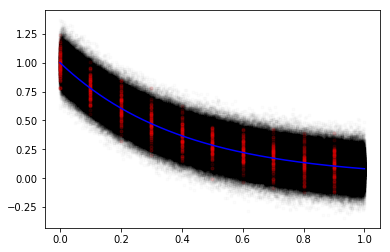

In [125]:
for i in range(N_data):
    plt.plot(t_vec, z_obs[i,:], '.k', alpha = 0.01)
for i in range(N_data):
    plt.plot(t_vec[::1000], z_obs[i,::1000], '.r', alpha = 0.1)
plt.plot(t_vec, y_true, 'b')
plt.show()

Now, infer the parameter

In [129]:
delta_T*1000


0.1

In [130]:
N_times = 10
1/N_times

0.1

In [131]:
1/(N_times*delta_T)

1000.0

In [133]:
dt_by

1000

In [135]:
z_obs[:,::dt_by].shape

(100, 10)

In [143]:
dt_by

1000

In [144]:
delta_T

0.0001

In [148]:
dt_by*delta_T

0.1

In [177]:
log = True

N_sample = 1000
start = -2.5
step = 0.1
N_lookat = 100
N_times = 1000
dt_by = int(1/(N_times*delta_T))
print("dt: ", dt_by*delta_T)

model = MetropolisHastings(prior=Gprior(0, 10, log), noise=Gprior(0,scale, log), delta_T=delta_T*dt_by, log=log)

model.fit(z_obs[:N_lookat,::dt_by], N_sample, start, step, silent=False)

np.mean(model.getPosterior(thin=0.1))


dt:  0.001
run loop for:  1000
acceptance rate:  0.326


-2.4966916916876802

In [175]:
model.likelihood(z_obs[:100, ::dt_by], -2.0)

655.575166664256

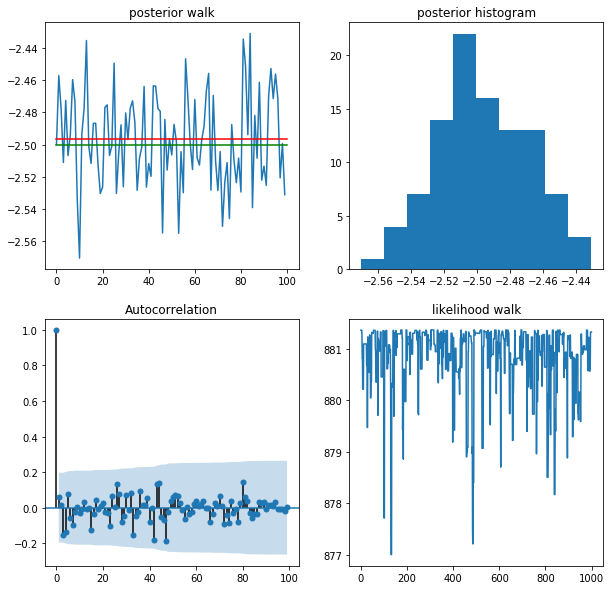

In [178]:
post = model.getPosterior(thin=0.1)
like = model.getLikelihood()

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.plot(post)
plt.plot([0, len(post)], [np.mean(post), np.mean(post)],color="red")
plt.plot([0, len(post)], [theta_true,theta_true],color="green")
plt.title("posterior walk")

plt.subplot(2,2,2)
plt.hist(post)
plt.title("posterior histogram")


ax2 = plt.subplot(2,2,3)
plot_acf(post, ax = ax2)

plt.subplot(2,2,4)
plt.plot(like)
plt.title("likelihood walk")




plt.show()

In [18]:
#mean_prior = 0
#noise_prior = 5
#noise_obs = scale

#N_lookat = 100
#mean_obs = np.mean(np.abs(z_obs[:N_lookat,:] - y_true))

#noise_true_var = (1/(noise_prior**2) + (N_lookat)/(noise_obs**2))**-1
#mean_true = noise_true_var * (mean_prior/(noise_prior**2) + N_lookat*mean_obs/(noise_obs**2) )
#print(noise_true)
#true_y = np.random.normal(mean_true, noise_true_var**0.5, 1000)

#prior = np.random.normal(mean_prior, noise_prior, 1000)
#true_y = np.random.normal(mean_obs, noise_obs, 1000)
#true_y = prior*likelihood

#sns.kdeplot(true_y, label = "true")
#sns.kdeplot(model.getPosterior(0.1), label = "computed")
#plt.show()

## How does the likelihood estimate depend on $N_\text{data}$?

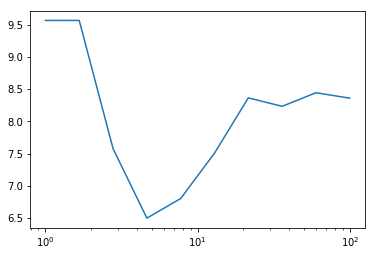

In [201]:
N_vec = np.logspace(0,2,10)

theta = -2.5

dt_by = 1000
model = MetropolisHastings(prior=Gprior(0, 10, log), noise=Gprior(0,scale, log), delta_T=delta_T*dt_by, log=log)

like_N = []
for i in N_vec:
    N = int(i) # make sure that we have int(s).
    like_N.append(model.likelihood(z_obs[:N,::dt_by], theta))
    
plt.semilogx(N_vec, like_N)
plt.show()

### An accuracy estimate

In [66]:
def comp_bias(post, truth):
    bias = np.mean(post) - truth
    return(bias)

print("MAP: ", np.mean(post))
print("bias: ", comp_bias(post, theta_true))

MAP:  -2.6221917884106274
bias:  -0.12219178841062739


We see that the solution in convering to the wrong answer.

# How does the error (|bias|) converge as $N_\text{data}$ increases

In [90]:
z_obs.shape

(100, 10)

In [93]:
N_vec = np.logspace(0,2,5)
theta_start = -2.5
rep = 25
df_bias = pd.DataFrame({"id":range(rep)})

## MCMC parameters
N_sample = 1000
step_vec = [1,1,1,1,1]

np.random.seed(0)
for i in range(len(N_vec)):
    N = int(N_vec[i])
    print(str(N))
    biasEst = []
    for j in range(rep):
        model.reSeed(np.random.randint(1000))
        model.fit(z_obs[:N,:], N_sample, theta_start, step_vec[i], silent=True)
        posterior = model.getPosterior()
        biasEst.append(comp_bias(posterior, theta_true))
    df_bias["N:" + str(N)] = np.abs(biasEst)
print("done")




1
3
10
31
100
done


spread of the (mean) bias


N:  1 mean:	 0.4541 	std:  0.0263
N:  3 mean:	 0.0259 	std:  0.0217
N:  10 mean:	 0.2222 	std:  0.0405
N:  31 mean:	 0.0634 	std:  0.0407
N:  100 mean:	 0.0706 	std:  0.0304


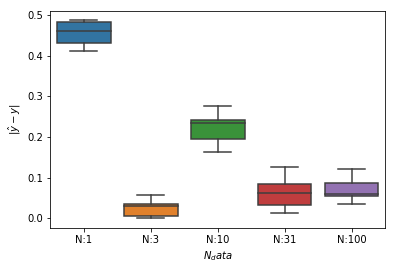

In [94]:
meanvec = []
stdvec = []
for i in range(len(N_vec)):
    meanvec.append(df_bias.iloc[:,i+1].mean())
    stdvec.append(df_bias.iloc[:,i+1].std())
    print("N: ", int(N_vec[i]), 
          "mean:\t", np.round(meanvec[i],4), 
          "\tstd: ", np.round(stdvec[i],4))
    
sns.boxplot(data=df_bias.iloc[:,1:])
plt.xlabel("$N_data$")
plt.ylabel("$|\hat{y} - y|$")
plt.show()

loglog plot of the mean error

In [24]:
pfit = np.polyfit(np.log(N_vec),np.log(meanvec),1)
print(pfit)
pval = np.polyval(pfit, np.log(N_vec))

[-0.10142977 -0.90886876]


Text(0, 0.5, '$|E[\\hat{y}] - y|$')

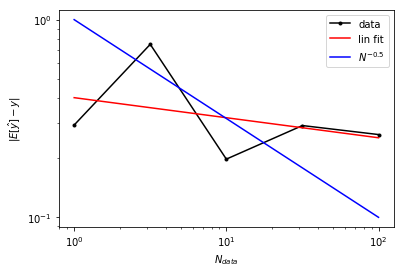

In [25]:
plt.loglog(N_vec, meanvec, '.-k')
plt.loglog(N_vec, np.exp(pval), '-r')
plt.loglog(N_vec, N_vec**(-0.5), '-b')
plt.legend(["data","lin fit","$N^{-0.5}$"])
plt.xlabel("$N_{data}$")
plt.ylabel("$|E[\hat{y}] - y|$")

## How does the error converge as $\Delta t \rightarrow 0$?

Given a fixed $N_\text{data}$, we study how the error converge as $\Delta t \rightarrow 0$.

delta_T = 1e-4
#bias = np.empty(len(delta_T_vec))

N_sample = 10000
start = -2.5

N_data = 10

# we double the timestep 8 times.
N_steps = 8 
step_vec = [0.12, 0.22, 0.4, 0.7, 1.2, 3, 10, 10]


theta_true = -2.5
scale = 0.5

log = True


#delta_T_i = delta_T_vec[i]
#step_i = step_vec[i]
   
t_vec = np.linspace(0,1,int(1/delta_T))

y_true = model_analytic(theta_true, t_vec)

z_obs = observation(y_true, scale)


bias = np.empty(N_steps)
delta_T_vec = np.empty(N_steps)
model_list = []

by = 1
np.random.seed(0)
for i in range(N_steps):
    print(by)
    t_vec_i = t_vec[::by]
    delta_T_vec[i] = delta_T_i = delta_T*by
    z_obs_i = z_obs[::by]
    
    step_i = step_vec[i]
        
    model = MetropolisHastings(prior=Gprior(0, 10, log), noise=Gprior(0,scale, log), delta_T=delta_T_i, log=log)
    model.fit(z_obs_i, N_sample, start, step_i)
    
    model_list.append(model)
    
    post = model.getPosterior()
    bias[i] = comp_bias(post, theta_true)
    if(i % 2 == 0):
        by *= 5
    else:
        by *= 2
    

print("done")

# fit a linear polynomial to the error
log_err = np.log(np.abs(bias))
log_dt = np.log(delta_T_vec)

p_fit = np.polyfit(log_dt, log_err, 1)
err_fit = np.exp(np.polyval(p_fit, log_dt))

print("lin. fit: ", p_fit)

by = 1
x = []
for i in range(N_steps):
    x.append(1/np.sqrt(len(z_obs[::by])))
    if(i % 2 == 0):
        by *= 5
    else:
        by *= 2
x

N_data_vec = 1/delta_T_vec
print("delta_T: ", delta_T_vec)
print("N_data: ", N_data_vec)

plt.loglog(N_data_vec,np.abs(bias), '.-b')
plt.loglog(N_data_vec, err_fit, '--r')
plt.loglog(N_data_vec, x, '-.g')
plt.legend(["error", "lin. fit", "1/sqrt(N_data)"])
plt.xlabel("N_data")
plt.ylabel("error")
plt.show()

thin = 1
df_post = pd.DataFrame({"sample_id": range(int(N_sample*thin))})
post0 = model_list[0].getPosterior()
## add columns for each posterior sample
for i in range(N_steps):
    df_post["dt: " + str(delta_T_vec[i])] = model_list[i].getPosterior(thin=thin)

    


df_post.head()

model_list[0].plot()

model_list[7].plot()

thinned = 10
plt.figure(figsize=(15,5))
ax0 = plt.subplot(1,2,1)
sns.kdeplot(df_post.iloc[::thinned,1])
sns.kdeplot(df_post.iloc[::thinned,2])
sns.kdeplot(df_post.iloc[::thinned,3])
sns.kdeplot(df_post.iloc[::thinned,4])

ax1 = plt.subplot(1,2,2)
sns.kdeplot(df_post.iloc[::thinned,5])
sns.kdeplot(df_post.iloc[::thinned,6])
sns.kdeplot(df_post.iloc[::thinned,7])
sns.kdeplot(df_post.iloc[::thinned,8])



plt.show()

these simulations suggests that each posterior converges to a mean that is not $\lambda$ but $\lambda_{\Delta t}$ 

for col in df_post.columns[1:]:
    mean = df_post.loc[::10,[col]].mean()[0]
    std = df_post.loc[::10,[col]].std()[0]
    print(col, "\t, mean: ", np.round(mean,4), ",\t std: ", np.round(std,4))
